In [1]:
%pylab inline
from qualityBaseline import *
from analysis_toolbox import *

Populating the interactive namespace from numpy and matplotlib


qualityBaseline.py:219: SyntaxWarning: import * only allowed at module level
  def compute_my_COCO_BBvals(compute_metrics=['simple','area','dist']):


In [117]:
# from matplotlib.patches import Polygon
# from matplotlib.collections import PatchCollection

# fig, ax = plt.subplots()
# patches = []
# #div by 10 because for some reason Polygon only take [0,1]
# polygon = Polygon(coord_to_bb(bbw,bbh,'all')/10, False)
# patches.append(polygon)
# p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
# ax.add_collection(p)

In [128]:
def coord_to_bb(bbw,bbh,type='model'): 
    '''
    Given 4 coordinates, 
    if all : generate the set of 4 coordinates (x,y) for this BB
    if model : generate the set of top-left and lower right coordinates (x,y) for this BB
    '''
    bbw = sort(bbw)
    bbh = sort(bbh)
    if type=="all":
        return np.array([[bbw[0],bbh[1]],
                [bbw[1],bbh[1]],
                [bbw[1],bbh[0]],
                [bbw[0],bbh[0]],
               ],dtype=float)
    elif type=="model":
#         return np.array([[bbw[0],bbh[1]],
#                 [bbw[1],bbh[0]]
#                ])
        # (x1,y1,x2,y2)
        return np.array([bbw[0],bbh[1],bbw[1],bbh[0]])

In [129]:
# Generate Synthetic Bounding Boxes 
img_width=5
img_height=10
N_sample = 10
random.seed(131)

data =[]
for _i in range(N_sample):
    bbw = [random.randint(img_width,img_height) for x in range(2)]
    bbh = [random.randint(img_width,img_height) for x in range(2)]
    data.append(coord_to_bb(bbw,bbh,'model'))

#### Variable defintions

|Math notation  | Variable name | Meaning|
| ------------- |:-------------:| -----|
|$\mathcal{I}$ | I|set of all images seen |
|$\mathcal{U}$ | U|set of all images |
|$\mathcal{E}$ | E|expert list|
|$\mathcal{B}$ | B|'bot' (bad workers) list|
|$p(l_{ij}|z_i)$ | plij|posterior|
|$p(a_j)$ | pa| prob of honest worker|

In [ ]:
# EM algorithm 
for lij in data: 

In [133]:
img_info,object_tbl,bb_info,hit_info = load_info()

In [145]:
U = list(img_info.id)

In [141]:
I = []
L = []
E = []
B = []
U=[]
while len(I)<len(U): 
    # add a image in U but not in I (pick randomly)
    I.append(random.choice([u for u in U if u not in I ]))
    # Looping through all the seen images 
    for i in I: 
    

# Aligning bounding boxes


1. subsample 50 points 
2. compute distance to origin 
3. find point with min distance to origin 
4. determine clockwise or counter clockwise by:
    seeing if the next array element is to the right of this point 

In [9]:
from collections import OrderedDict

In [109]:
import warnings
warnings.filterwarnings("ignore")

from scipy.interpolate import splprep,splev
def single_parametric_interpolate(obj_x_loc,obj_y_loc,numPts=50,PLOT=False):
    '''
    Interpolate a single given bounding box obj_x_loc,obj_y_loc
    return a new set of coordinates interpolated on numPts 
    '''
    tck, u =splprep(np.array([obj_x_loc,obj_y_loc]),s=0,per=1)
    u_new = np.linspace(u.min(),u.max(),numPts)
    new_points = splev(u_new, tck,der=0)
    return new_points

In [108]:
ixlocs,iylocs = single_parametric_interpolate(worker_x_locs,worker_y_locs)

In [46]:
icoord = np.array(zip(ixlocs,iylocs)) #interpolated coordinates

In [59]:
# find point with min distance to origin
oidx=np.argmin(sqrt(icoord[:,0]**2+icoord[:,1]**2))

In [83]:
# aligning coordinates
if icoord[oidx][0] <icoord[oidx+1][0]:
    print "CW"
    aicoord = np.concatenate((icoord[oidx:],icoord[:oidx]))
else: 
    print "CCW"
    aicoord = np.concatenate((icoord[:oidx][::-1],icoord[oidx:][::-1]))

CW


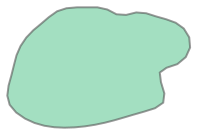

In [84]:
Polygon(aicoord)

In [187]:
img_info,object_tbl,bb_info,hit_info = load_info()
bb_info =bb_info[bb_info["object_id"]==10]
coord_lst =[]
icoord_lst =[]
aicoord_lst =[]
for bb in tqdm(list(bb_info.iterrows())):
    oid = bb[1]["object_id"]
    #Image information 
    image_id = int(object_tbl[object_tbl.object_id==oid].image_id)
    img_name = img_info["filename"][image_id-1]

    bbx_path= bb[1]["x_locs"]
    bby_path= bb[1]["y_locs"]
    worker_x_locs,worker_y_locs= process_raw_locs([bbx_path,bby_path])
    worker_x_locs,worker_y_locs = zip(*list(OrderedDict.fromkeys(zip(worker_x_locs,worker_y_locs))))
    coord_lst.append(zip(worker_x_locs,worker_y_locs))
    
    ixlocs,iylocs = single_parametric_interpolate(worker_x_locs,worker_y_locs)
    icoord = np.array(zip(ixlocs,iylocs)) #interpolated coordinates
    icoord_lst.append(icoord)
    # find point with min distance to origin
    oidx=np.argmin(sqrt(icoord[:,0]**2+icoord[:,1]**2))
#     print oidx
    # aligning coordinates
    try:
        next_coord  = icoord[oidx+1]
    except(IndexError):
        # oidx is last element of the array
        next_coord  = icoord[0]
    if icoord[oidx][0] <next_coord[0]:
#         print "CW"
        aicoord = np.concatenate((icoord[oidx:-1],icoord[:oidx]))
    else: 
#         print "CCW"
        aicoord = np.concatenate((icoord[:oidx-1][::-1],icoord[oidx:][::-1]))
    aicoord_lst.append(aicoord)

  0%|          | 0/44 [00:00<?, ?it/s]

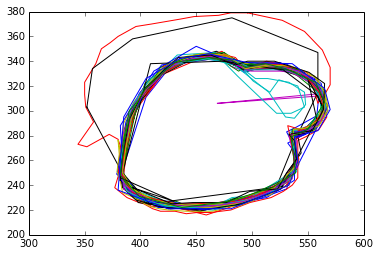

In [127]:
for xy in coord_lst:
    x,y = Polygon(xy).exterior.xy
    plt.plot(x,y)

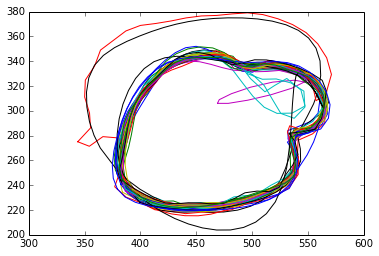

In [104]:
for xy in aicoord_lst:
    x,y = Polygon(xy).exterior.xy
    plt.plot(x,y)

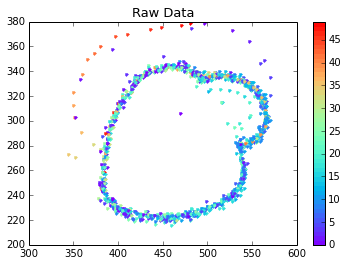

In [223]:
selected_idx=range(50)
steps = np.linspace(0, 1, len(selected_idx))
colors = cm.rainbow(steps)
Z = [[0,0],[0,0]]
CS3 = plt.contourf(Z, selected_idx, cmap=cm.rainbow)
plt.clf()
plt.colorbar(CS3) 
len_lst = []
for coord in coord_lst:
    len_lst.append(len(coord))
    for i in range(len(coord)):
        x,y = coord[i]
#         print i
        plt.plot(x,y,'.',color=colors[selected_idx.index(i)],label = "Point {}".format(i))    
plt.title("Raw Data",fontsize=13)
plt.savefig('raw_data.pdf')

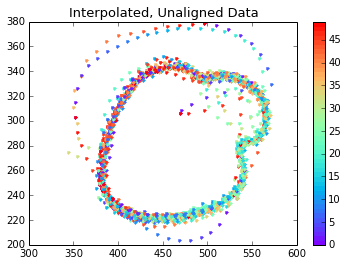

In [222]:
selected_idx=range(50)
steps = np.linspace(0, 1, len(selected_idx))
colors = cm.rainbow(steps)
Z = [[0,0],[0,0]]
CS3 = plt.contourf(Z, selected_idx, cmap=cm.rainbow)
plt.clf()
plt.colorbar(CS3)
len_lst = []
for coord in icoord_lst:
    len_lst.append(len(coord))
    for i in range(len(coord)):
        x,y = coord[i]
#         print i
        plt.plot(x,y,'.',color=colors[selected_idx.index(i)],label = "Point {}".format(i))    
plt.title("Interpolated, Unaligned Data",fontsize=13)
plt.savefig('interpolated_unaligned_data.pdf')

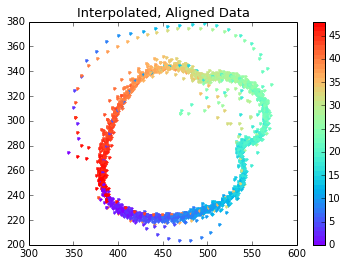

In [221]:
selected_idx=range(49)
steps = np.linspace(0, 1, len(selected_idx))
colors = cm.rainbow(steps)
Z = [[0,0],[0,0]]
CS3 = plt.contourf(Z, selected_idx, cmap=cm.rainbow)
plt.clf()
plt.colorbar(CS3)
colors = cm.rainbow(np.linspace(0, 1, len(selected_idx)))
for coord in aicoord_lst:
    for i in selected_idx:
        x,y = coord[i]
        plt.plot(x,y,'.',color=colors[selected_idx.index(i)],label = "Point {}".format(i))    
plt.title("Interpolated, Aligned Data",fontsize=13)
plt.savefig('interpolated_aligned_data.pdf')